    1. 데이터분석 및 유의 변수 선정
    - unbalance vs balance
    - histogram

    2. 데이터 전처리
    - normalize
    - pca 여부

    3. 모델 각각 hyper parameter 조정
    - pipeline활용
    (logistic, decision tree, random forest, adaboost, neural net)
    - 성과지표 활용
    (recall, accuracy, f1 score 등)

    4. 모델 성과비교 및 최종 모델 선정
    - predict

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [2]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings(action='ignore')
%matplotlib inline

Using TensorFlow backend.


### 데이터 전처리 및 분석

In [ ]:
def hist(df, class1, class2, col_num) :
    sns.kdeplot(df[df.iloc[:, -1] == class1].iloc[:,col_num], label='Good')
    sns.kdeplot(df[df.iloc[:, -1] == class2].iloc[:,col_num], label='Bad')
    col_name = df.columns[col_num]
    plt.title(col_name)
    plt.show()

In [3]:
train_data = pd.read_csv('train.csv')
train_data = train_data.iloc[:,1:]

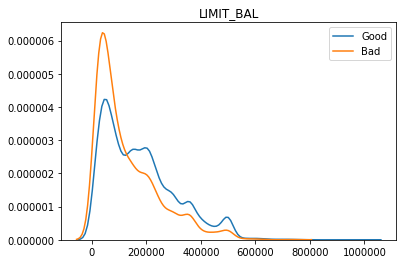

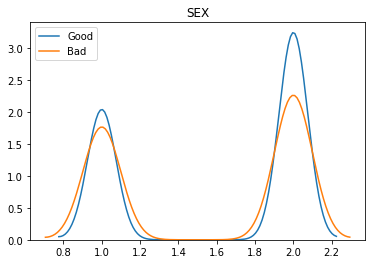

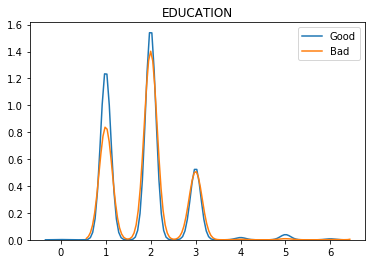

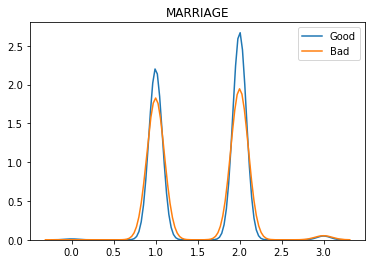

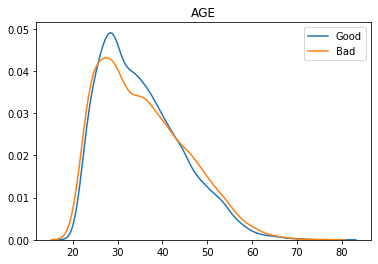

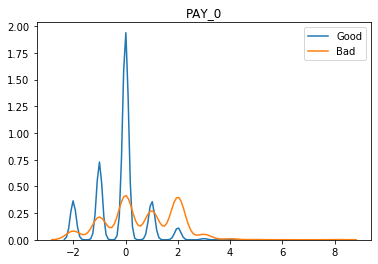

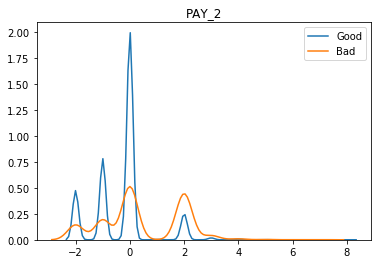

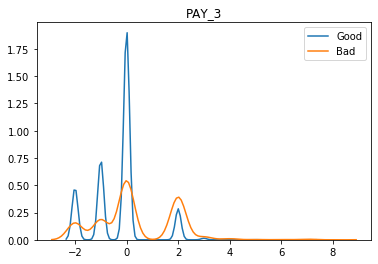

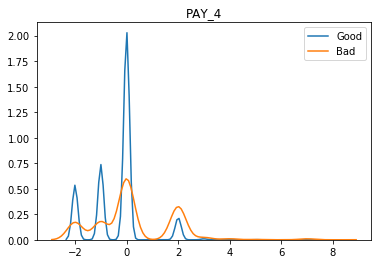

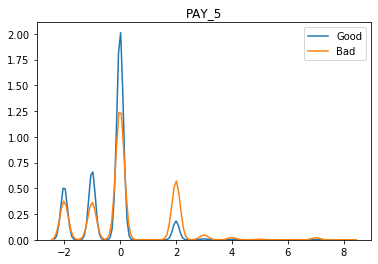

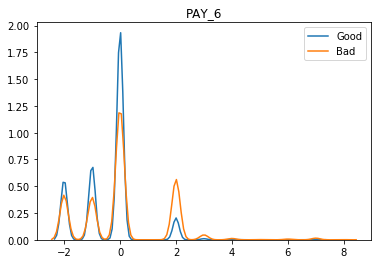

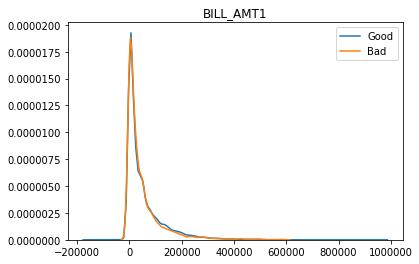

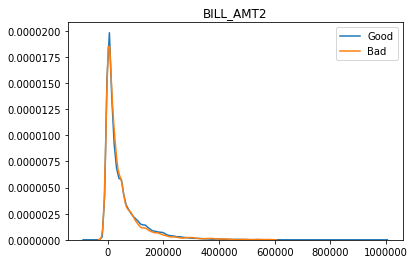

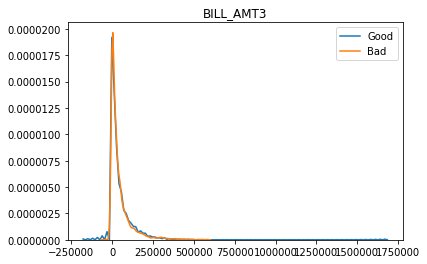

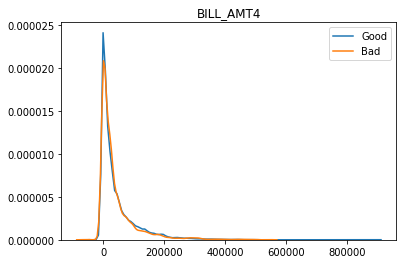

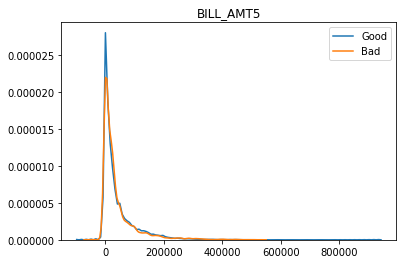

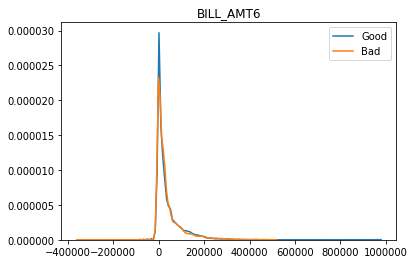

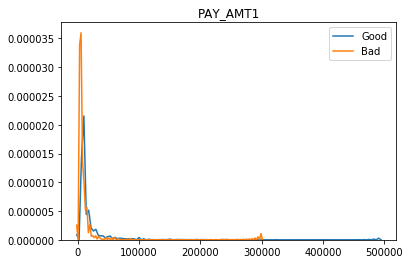

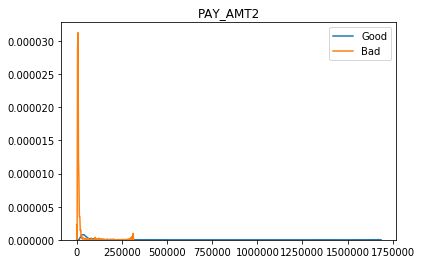

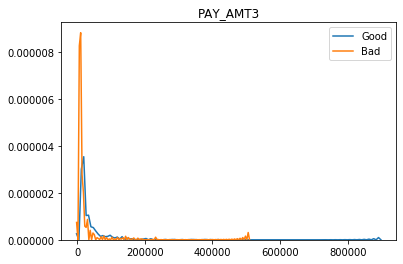

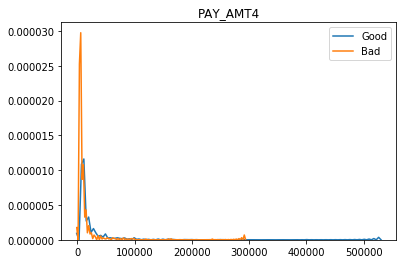

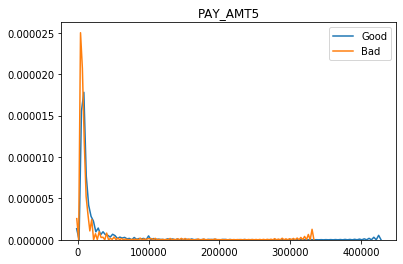

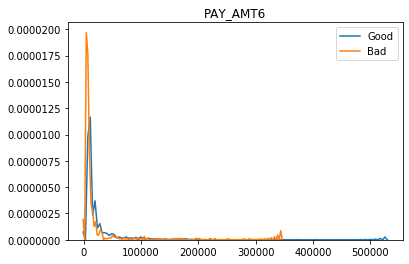

In [13]:
# y - label 제외 X의 갯수
X_number = len(train_data.columns) - 1
for i in range(X_number):
    hist(train_data, 0, 1, i)

In [4]:
train = train_data.iloc[:, :-1]
y = train_data.iloc[:, -1]
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(train))
X.columns = train.columns

In [15]:
# 다음달 부도나지 않은사람 수
len(y[y == 0])

15585

In [16]:
# 다음달 부도난 사람 수
len(y[y == 1])

4415

In [17]:
# unbalanced된 data임을 알 수 있음 accuracy를 조심히 봐야함.
# 다음달 부도난 사람 비율 22%
# 다음달 부도나지 않은 사람 비율 77.9%
# 전부 부도나지 않는다고 예측해도 77.9%는 나오게 됨
# accuracy 77.9%를 min 값으로 잡으면 될 듯
print(len(y[y == 1]) / (len(y[y == 0]) + len(y[y == 1])))
print(len(y[y == 0]) / (len(y[y == 0]) + len(y[y == 1])))

0.22075
0.77925


###  모델 hyperparameter 조정

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=123,
                                                    shuffle = True)
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.3,
                                                    random_state=123,
                                                    shuffle = True)

In [19]:
class StupidClassifier():
    def __init__(self):
        pass
    def fit(self, X, y):
        self.y = np.bincount(y).argmax()
    def score(self, X, y):
        return y.tolist().count(self.y)/len(y)

In [234]:
models_stupid = {'Stupid'               : make_pipeline(StupidClassifier())
         }

models = {'Logistic Regression'  : make_pipeline(LogisticRegression()),
          'SVM'                  : make_pipeline(SVC()),
          'Random Forest'        : make_pipeline(RandomForestClassifier()),
          'XGBoost'              : make_pipeline(XGBClassifier()),
          'Neural Network'       : make_pipeline(MLPClassifier())
         }

models2 = {
          'Neural Network'       : make_pipeline(MLPClassifier()),
          'PCA2 Neural Network'   : make_pipeline(PCA(2), MLPClassifier()),
          'PCA3 Neural Network'   : make_pipeline(PCA(3), MLPClassifier()),
          'PCA5 Neural Network'   : make_pipeline(PCA(5), MLPClassifier()),
         }

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'recall' : make_scorer(recall_score)}

kfold = model_selection.KFold(n_splits=3, shuffle = True)

In [21]:
# stupid : 부도 안난 애들이 더 많으므로 전부 부도가 안났다고 선택해서 77.9%
for name, model in models_stupid.items():
    model.fit(X_train_, y_train_)
    print(f'{name: <20}', end='\t')
    print(f'{model.score(X_val, y_val): .3f}', end='\t')

Stupid              	 0.779	

In [229]:
for name, model in models.items():
    # 모든 string의 사이즈를 20으로 맞춤, '\t'는 한줄 띄워서 출력
    print(f'{name: <20}', end='\t')
    results = pd.DataFrame(model_selection.cross_validate(estimator=model,
                                          X=X_train,
                                          y=y_train,
                                          cv=kfold,
                                          scoring=scoring)).mean()

    results.loc['myscore'] = 2/(1/results[2] + 1/results[3])
    # 첫번째컬럼 train set에서의 accuracy / 두번째컬럼 test set에서의 accuracy
    accuracy = results[2]
    recall = results[3]
    myscore = 2/(1/recall + 1/accuracy)
    print(f'{accuracy: .5f}', end='\t')
    print(f'{recall: .5f}', end = '\t')
    print(f'{myscore: .5f}')
    
    # 첫번째컬럼 train set에서의 accuracy / 두번째컬럼 test set에서의 accuracy

Logistic Regression 	 0.81093	 0.24155	 0.37222
SVM                 	 0.81957	 0.33523	 0.47583
Random Forest       	 0.81529	 0.36396	 0.50326
XGBoost             	 0.80979	 0.36580	 0.50395
Neural Network      	 0.80836	 0.35425	 0.49262
PCA Neural Network  	 0.80764	 0.36208	 0.50000


In [235]:
for name, model in models2.items():
    # 모든 string의 사이즈를 20으로 맞춤, '\t'는 한줄 띄워서 출력
    print(f'{name: <20}', end='\t')
    results = pd.DataFrame(model_selection.cross_validate(estimator=model,
                                          X=X_train,
                                          y=y_train,
                                          cv=kfold,
                                          scoring=scoring)).mean()

    results.loc['myscore'] = 2/(1/results[2] + 1/results[3])
    # 첫번째컬럼 train set에서의 accuracy / 두번째컬럼 test set에서의 accuracy
    accuracy = results[2]
    recall = results[3]
    myscore = 2/(1/recall + 1/accuracy)
    print(f'{accuracy: .5f}', end='\t')
    print(f'{recall: .5f}', end = '\t')
    print(f'{myscore: .5f}')
    
    # 첫번째컬럼 train set에서의 accuracy / 두번째컬럼 test set에서의 accuracy

Neural Network      	 0.80764	 0.35307	 0.49135
PCA2 Neural Network 	 0.80686	 0.33160	 0.47003
PCA3 Neural Network 	 0.80650	 0.31621	 0.45430
PCA5 Neural Network 	 0.80821	 0.30917	 0.44725


#### logistic

In [23]:
def calcul_logi_stat(X_, Y_, penalty_) :
    c_list = [0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100]
    accuracy_list = []
    recall_list = []
    myscore_list = []

    for c in c_list:
        params = {'C': c}
        if penalty_ == 'none' :
            logistic = LogisticRegression(solver = 'liblinear', **params , random_state=13)
            results = pd.DataFrame(model_selection.cross_validate(estimator=logistic,
                                                                            X=X_,
                                                                            y=Y_,
                                                                            cv=kfold,
                                                                            scoring=scoring)).mean()

            accuracy = results[2]
            recall = results[3]
            myscore = 2/(1/recall + 1/accuracy)

            accuracy_list.append(accuracy)
            recall_list.append(recall)
            myscore_list.append(myscore)
        else :
            logistic = LogisticRegression(solver = 'liblinear', penalty = penalty_, **params )
            results = pd.DataFrame(model_selection.cross_validate(estimator=logistic,
                                                                            X=X_,
                                                                            y=Y_,
                                                                            cv=kfold,
                                                                            scoring=scoring)).mean()

            accuracy = results[2]
            recall = results[3]
            myscore = 2/(1/recall + 1/accuracy)


            accuracy_list.append(accuracy)
            recall_list.append(recall)
            myscore_list.append(myscore)
        
    logi_stat = pd.DataFrame()
    logi_stat['c'] = list(map(lambda x: str(x), c_list))
    logi_stat['accuracy'] = accuracy_list
    logi_stat['recall'] = recall_list
    logi_stat['myscore'] = myscore_list
    logi_stat = logi_stat.set_index('c')
    
    return logi_stat

In [32]:
logi_stat = calcul_logi_stat(X_train, y_train,'none')

In [24]:
logi_l1_stat = calcul_logi_stat(X_train, y_train,'l1')

In [25]:
logi_l2_stat = calcul_logi_stat(X_train, y_train, 'l2')

#### svm

In [26]:
def calcul_svm_stat(X_, Y_, gamma_) :
    c_list = [0.01, 0.1, 0.5, 1, 5, 10]
    accuracy_list = []
    recall_list = []
    myscore_list = []

    for c in c_list:
            svm = SVC( kernel='rbf', gamma=gamma_, C=c, random_state=1 )
            results = pd.DataFrame(model_selection.cross_validate(estimator=svm,
                                                                            X=X_,
                                                                            y=Y_,
                                                                            cv=kfold,
                                                                            scoring=scoring)).mean()

            accuracy = results[2]
            recall = results[3]
            myscore = 2/(1/recall + 1/accuracy)

            accuracy_list.append(accuracy)
            recall_list.append(recall)
            myscore_list.append(myscore)
            
    svm_stat = pd.DataFrame()
    svm_stat['c'] = list(map(lambda x: str(x), c_list))
    svm_stat['accuracy'] = accuracy_list
    svm_stat['recall'] = recall_list
    svm_stat['myscore'] = myscore_list
    svm_stat = svm_stat.set_index('c')
    
    return svm_stat

In [27]:
svm_stat_1 = calcul_svm_stat(X_train, y_train, 0.001)

In [28]:
svm_stat_2 = calcul_svm_stat(X_train, y_train, 0.01)

In [29]:
svm_stat_3 = calcul_svm_stat(X_train, y_train, 0.05)

In [30]:
svm_stat_4 = calcul_svm_stat(X_train, y_train, 0.1)

In [116]:
# random forest & xgboost
def plot_learning_curves(model, X, y):
    X_train__, X_val__, y_train__, y_val__ = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)
    train_errors, val_errors = [], []
    train_size_list = list(range(10, 200, 10))
    for m in train_size_list:
        model.fit(X_train__[:m], y_train__[:m])
        y_train_predict = model.predict(X_train__[:m])
        y_val_predict = model.predict(X_val__)
        train_errors.append(mean_squared_error(y_train_predict, y_train__[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val__))
    
    learning_curve = pd.DataFrame()
    learning_curve['train_errors'] = np.sqrt(train_errors)
    learning_curve['val_errors'] = np.sqrt(val_errors)
    learning_curve['train_size'] = train_size_list
    learning_curve = learning_curve.set_index('train_size')
    
    plt.plot(learning_curve)
    plt.legend(learning_curve)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)  

In [117]:
dt_clf = DecisionTreeClassifier(random_state=156, max_depth = 1)

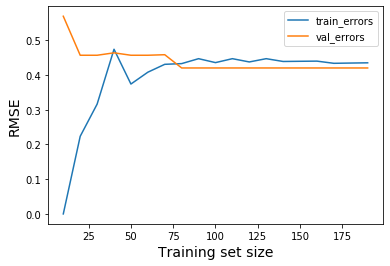

In [118]:
plot_learning_curves(dt_clf, X_train, y_train)

#### random forest

In [123]:
def calcul_rf_stat(model, X_, Y_, depth) :
    estimator_num_list = [50, 75, 100]
    accuracy_list = []
    recall_list = []
    myscore_list = []

    for estimator_num in estimator_num_list:
            model_ = model(n_estimators=estimator_num, 
                                max_depth=depth, 
                                random_state=0)
            results = pd.DataFrame(model_selection.cross_validate(estimator=model_,
                                                                            X=X_,
                                                                            y=Y_,
                                                                            cv=kfold,
                                                                            scoring=scoring)).mean()

            accuracy = results[2]
            recall = results[3]
            myscore = 2/(1/recall + 1/accuracy)

            accuracy_list.append(accuracy)
            recall_list.append(recall)
            myscore_list.append(myscore)
            
    model_stat = pd.DataFrame()
    model_stat['estimator_num'] = list(map(lambda x: str(x),estimator_num_list))
    model_stat['accuracy'] = accuracy_list
    model_stat['recall'] = recall_list
    model_stat['myscore'] = myscore_list
    model_stat = model_stat.set_index('estimator_num')
    
    return model_stat

In [133]:
rf_5_stat = calcul_rf_stat(RandomForestClassifier, X_train, y_train, 5)

In [134]:
rf_10_stat = calcul_rf_stat(RandomForestClassifier, X_train, y_train, 10)

In [135]:
rf_15_stat = calcul_rf_stat(RandomForestClassifier, X_train, y_train, 15)

In [142]:
rf_20_stat = calcul_rf_stat(RandomForestClassifier, X_train, y_train, 20)

#### xgboost

In [150]:
xg_2_stat = calcul_rf_stat(XGBClassifier, X_train, y_train, 2)

In [152]:
xg_3_stat = calcul_rf_stat(XGBClassifier, X_train, y_train, 3)

In [154]:
xg_4_stat = calcul_rf_stat(XGBClassifier, X_train, y_train, 4)

In [146]:
xg_5_stat = calcul_rf_stat(XGBClassifier, X_train, y_train, 5)

#### neural net

In [286]:
def build_model( n_hidden = 2, n_neurons = 100, learning_rate = 0.01, input_shape=[23]):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
        model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
        model.compile(loss='binary_crossentropy',metrics=[tf.keras.metrics.Recall()], optimizer=tf.keras.optimizers.Adam(learning_rate))

    return model

In [287]:
early_stop = EarlyStopping(monitor='recall', patience=10)
filename = os.path.join('./', 'credit_risk_prj')
checkpoint = ModelCheckpoint(filename, monitor='recall', verbose=1, save_best_only=True, mode='auto')

keras_classifier_best = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [289]:
keras_classifier_best.fit(X_train, y_train,epochs=20, validation_split=0.2,
                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)], verbose=2 )

Train on 11200 samples, validate on 2800 samples
Epoch 1/20
11200/11200 - 2s - loss: 0.4680 - recall_14: 0.2696 - val_loss: 0.4536 - val_recall_14: 0.4656
Epoch 2/20
11200/11200 - 1s - loss: 0.4550 - recall_14: 0.4499 - val_loss: 0.4603 - val_recall_14: 0.3728
Epoch 3/20
11200/11200 - 1s - loss: 0.4503 - recall_14: 0.4236 - val_loss: 0.4599 - val_recall_14: 0.4480
Epoch 4/20
11200/11200 - 1s - loss: 0.4553 - recall_14: 0.3953 - val_loss: 0.4520 - val_recall_14: 0.3808
Epoch 5/20
11200/11200 - 1s - loss: 0.4440 - recall_14: 0.4491 - val_loss: 0.4528 - val_recall_14: 0.4048
Epoch 6/20
11200/11200 - 1s - loss: 0.4392 - recall_14: 0.4386 - val_loss: 0.4479 - val_recall_14: 0.4304
Epoch 7/20
11200/11200 - 1s - loss: 0.4398 - recall_14: 0.4466 - val_loss: 0.4411 - val_recall_14: 0.4128
Epoch 8/20
11200/11200 - 1s - loss: 0.4364 - recall_14: 0.4349 - val_loss: 0.4476 - val_recall_14: 0.4128
Epoch 9/20
11200/11200 - 1s - loss: 0.4367 - recall_14: 0.4325 - val_loss: 0.4705 - val_recall_14: 0.31

### 모델 성과 비교 및 최종 모델 선정

In [ ]:
# logistic의 최종 parameter : c = 5 / penalty = 'l1'
# svm 최종 parameter : c = 10 / gamma = 0.05
# random forest parameter : n_estimator: 100 / depth : 20
# xg boost parameter : estimator_num = 75 / depth = 5
# neural_net best parameter = learning_rate 0.1, layor= 3, n_neurons = 100

In [304]:
logistic = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 5, random_state = 10 )

svm = SVC( kernel='rbf', gamma=0.05, C=10, random_state=10 )

rf = RandomForestClassifier(n_estimators=100, 
                                max_depth=20, 
                                random_state=10)

xgb = XGBClassifier(n_estimators=75, 
                                max_depth=5, 
                                random_state=10)

In [305]:
best_models = {'Logistic Regression'  : make_pipeline(logistic),
          'SVM'                  : make_pipeline(svm),
          'Random Forest'        : make_pipeline(rf),
          'XGBoost'              : make_pipeline(xgb),
          'Neural Network'       : make_pipeline(keras_classifier_best),
         }

In [309]:
for name, model in best_models.items():
    # 모든 string의 사이즈를 20으로 맞춤, '\t'는 한줄 띄워서 출력
    print(f'{name: <20}', end='\t')
    model.fit(X_train, y_train)

    results.loc['myscore'] = 2/(1/results[2] + 1/results[3])
    accuracy = accuracy_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    myscore = 2/(1/recall + 1/accuracy)
    print(f'{accuracy: .5f}', end='\t')
    print(f'{recall: .5f}', end = '\t')
    print(f'{myscore: .5f}')


Logistic Regression 	 0.80967	 0.23024	 0.35853
SVM                 	 0.81550	 0.34195	 0.48185
Random Forest       	 0.81517	 0.36018	 0.49961
XGBoost             	 0.81517	 0.36018	 0.49961
14000/14000 [==============================] - 1s 99us/sample - loss: 0.4686 - recall_26: 0.3111
 0.81317	 0.41185	 0.54678


In [ ]:
# 최종모델은 neural_net, parameter는 learning_rate 0.1, layor= 3, n_neurons = 100

### Final 모델 fitting & predict

In [7]:
ans_sheet = pd.read_excel('ans_sheet.xlsx')

In [8]:
test = pd.read_csv('test.csv')

In [9]:
test = test.iloc[:,1:]

In [28]:
scaler = StandardScaler()

final_test = pd.DataFrame(scaler.fit_transform(test))
final_test.columns = test.columns

In [11]:
def build_model( n_hidden = 2, n_neurons = 100, learning_rate = 0.01, input_shape=[23]):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
        model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
        model.compile(loss='binary_crossentropy',metrics=[tf.keras.metrics.Recall()], optimizer=tf.keras.optimizers.Adam(learning_rate))

    return model

In [23]:
early_stop = EarlyStopping(monitor='recall', patience=2)
filename = os.path.join('./', 'credit_risk_prj')
checkpoint = ModelCheckpoint(filename, monitor='recall', verbose=1, save_best_only=True, mode='auto')

keras_classifier_final = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [24]:
keras_classifier_final.fit(X, y,epochs=5, validation_split=0.2,
                         callbacks=[early_stop, checkpoint], verbose=2 )

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 - 2s - loss: 0.4684 - recall_9: 0.3110 - val_loss: 0.4482 - val_recall_9: 0.3595
Epoch 2/5
16000/16000 - 2s - loss: 0.4514 - recall_9: 0.4234 - val_loss: 0.4411 - val_recall_9: 0.4486
Epoch 3/5
16000/16000 - 2s - loss: 0.4498 - recall_9: 0.4279 - val_loss: 0.4494 - val_recall_9: 0.3954
Epoch 4/5
16000/16000 - 2s - loss: 0.4480 - recall_9: 0.4301 - val_loss: 0.4367 - val_recall_9: 0.4301
Epoch 5/5
16000/16000 - 2s - loss: 0.4447 - recall_9: 0.4237 - val_loss: 0.4392 - val_recall_9: 0.4809


In [29]:
final_pred = keras_classifier_final.predict(final_test)

In [34]:
ans_sheet.iloc[:,2] = final_pred

In [39]:
final_proba = keras_classifier_final.predict_proba(final_test)

In [44]:
final_proba_list = final_proba[final_proba > 0.5].tolist()

In [47]:
ans_sheet.iloc[:,1] = final_proba_list

In [54]:
ans_sheet.to_excel('ans_sheet_revised.xlsx')

In [57]:
ans_sheet

,ID,Y (probability),"prediction (default:1, no default: 0)"
0,2,0.621501,1
1,5,0.875220,0
2,8,0.829622,0
3,11,0.765218,0
4,14,0.640292,1
...,...,...,...
9995,29987,0.880815,0
9996,29990,0.845551,0
9997,29993,0.753998,0
9998,29996,0.889200,0


### 통계표 정리

#### logistic

In [33]:
logi_stat

,accuracy,recall,myscore
c,,,
0.01,0.809499,0.233622,0.362598
0.1,0.810429,0.236523,0.366177
0.25,0.811072,0.237666,0.367612
0.5,0.810572,0.237706,0.367608
0.75,0.810500,0.238455,0.368496
1,0.811429,0.242367,0.373248
5,0.809857,0.235476,0.364864
10,0.810571,0.239299,0.369510
100,0.811428,0.241703,0.372460


In [34]:
logi_l1_stat

,accuracy,recall,myscore
c,,,
0.01,0.807214,0.202215,0.323412
0.1,0.810643,0.232626,0.361511
0.25,0.810714,0.237649,0.367554
0.5,0.810286,0.235953,0.365479
0.75,0.810428,0.239875,0.370181
1,0.810857,0.238176,0.368199
5,0.811357,0.243037,0.374034
10,0.810214,0.236596,0.366243
100,0.811214,0.239729,0.370090


In [35]:
logi_l2_stat

,accuracy,recall,myscore
c,,,
0.01,0.809357,0.231979,0.360602
0.1,0.810000,0.234094,0.363216
0.25,0.810572,0.238758,0.368865
0.5,0.809643,0.237932,0.367783
0.75,0.810714,0.236996,0.366773
1,0.809857,0.235946,0.365427
5,0.811001,0.239276,0.369528
10,0.810286,0.237110,0.366866
100,0.808857,0.234923,0.364098


In [36]:
print(logi_stat['accuracy'].max())
print(logi_l1_stat['accuracy'].max())
print(logi_l2_stat['accuracy'].max())

0.8114286613475316
0.8113572378777794
0.8110009318114656


In [215]:
print(logi_stat['recall'].max())
print(logi_l1_stat['recall'].max())
print(logi_l2_stat['recall'].max())

0.24236689429315772
0.2430366886454263
0.23927643879784935


In [216]:
print(logi_l1_stat['recall'].idxmax())

5


In [39]:
# logistic의 최종 parameter : c = 5 / penalty = 'l1'

#### svm

In [41]:
# gamma = 0.001
svm_stat_1

,accuracy,recall,myscore
c,,,
0.01,0.778643,0.000000,0.000000
0.1,0.778643,0.000000,0.000000
0.5,0.780286,0.015454,0.030307
1,0.785429,0.051405,0.096494
5,0.804428,0.198387,0.318280
10,0.809429,0.245257,0.376449


In [42]:
# gamma = 0.01
svm_stat_2

,accuracy,recall,myscore
c,,,
0.01,0.778643,0.000000,0.000000
0.1,0.806072,0.220570,0.346363
0.5,0.814928,0.302373,0.441084
1,0.816429,0.312485,0.451977
5,0.818786,0.320897,0.461086
10,0.818786,0.326246,0.466582


In [43]:
# gamma = 0.05
svm_stat_3

,accuracy,recall,myscore
c,,,
0.01,0.778714,0.000326,0.000651
0.1,0.811857,0.281202,0.417719
0.5,0.819356,0.332451,0.472989
1,0.819286,0.330791,0.471295
5,0.819643,0.342875,0.483494
10,0.816715,0.346579,0.486646


In [44]:
# gamma = 0.1
svm_stat_4

,accuracy,recall,myscore
c,,,
0.01,0.778643,0.000000,0.000000
0.1,0.811429,0.274236,0.409929
0.5,0.817214,0.316016,0.455781
1,0.819714,0.331435,0.472019
5,0.809643,0.328948,0.467824
10,0.803714,0.341055,0.478892


In [47]:
print(svm_stat_1['accuracy'].max())
print(svm_stat_2['accuracy'].max())
print(svm_stat_3['accuracy'].max())
print(svm_stat_4['accuracy'].max())

0.8094285286645834
0.8187862124721788
0.8196427583566455
0.8197144114346373


In [217]:
print(svm_stat_1['recall'].max())
print(svm_stat_2['recall'].max())
print(svm_stat_3['recall'].max())
print(svm_stat_4['recall'].max())

0.2452567923815957
0.32624593445296646
0.34657936603714967
0.341054637204723


In [49]:
print(svm_stat_1['accuracy'].idxmax())
print(svm_stat_2['accuracy'].idxmax())
print(svm_stat_3['accuracy'].idxmax())
print(svm_stat_4['accuracy'].idxmax())

10
10
5
1


In [218]:
print(svm_stat_1['recall'].idxmax())
print(svm_stat_2['recall'].idxmax())
print(svm_stat_3['recall'].idxmax())
print(svm_stat_4['recall'].idxmax())

10
10
10
10


In [51]:
# svm 최종 parameter : c = 10 / gamma = 0.05

#### random forest

In [137]:
rf_5_stat

,accuracy,recall,myscore
estimator_num,,,
50,0.814786,0.288198,0.425790
75,0.817643,0.304188,0.443413
100,0.817429,0.305613,0.444893


In [139]:
rf_10_stat

,accuracy,recall,myscore
estimator_num,,,
50,0.819642,0.350762,0.491282
75,0.818929,0.348534,0.488966
100,0.819500,0.351169,0.491656


In [140]:
rf_15_stat

,accuracy,recall,myscore
estimator_num,,,
50,0.817142,0.352044,0.492086
75,0.817000,0.352378,0.492386
100,0.819072,0.357500,0.497748


In [143]:
rf_20_stat

,accuracy,recall,myscore
estimator_num,,,
50,0.816071,0.355749,0.495497
75,0.812714,0.357082,0.496165
100,0.815857,0.359032,0.498633


In [ ]:
# random forest parameter : n_estimator: 100 / depth : 20

#### xg boost

In [157]:
xg_2_stat 

,accuracy,recall,myscore
estimator_num,,,
50,0.820143,0.348511,0.489159
75,0.821000,0.357497,0.498100
100,0.821500,0.357997,0.498678


In [158]:
xg_3_stat 

,accuracy,recall,myscore
estimator_num,,,
50,0.821857,0.360394,0.501065
75,0.820071,0.365277,0.505427
100,0.819214,0.364989,0.504988


In [159]:
xg_4_stat 

,accuracy,recall,myscore
estimator_num,,,
50,0.818714,0.366373,0.506216
75,0.816500,0.360578,0.500242
100,0.817500,0.369210,0.508683


In [160]:
xg_5_stat

,accuracy,recall,myscore
estimator_num,,,
50,0.816071,0.368062,0.507316
75,0.817143,0.369986,0.509349
100,0.813071,0.361910,0.500874


In [ ]:
# xg boost parameter : estimator_num = 75 / depth = 5

#### neural net

In [293]:
accuracy_score(y_val, keras_classifier_best.predict(X_val))

0.8164285714285714

In [294]:
recall_score( y_val, keras_classifier_best.predict(X_val))

0.45806451612903226

In [295]:
confusion_matrix( y_val, keras_classifier_best.predict(X_val))

array([[3003,  267],
       [ 504,  426]], dtype=int64)

In [214]:
# neural_net best parameter = learning_rate 0.1, layor= 3, n_neurons = 100

    {'learning_rate': 0.01, 'n_hidden': 2, 'n_neurons': 100}    0.471606
    {'learning_rate': 0.01, 'n_hidden': 3, 'n_neurons': 75}     0.465498
    {'learning_rate': 0.01, 'n_hidden': 3, 'n_neurons': 100}    0.459478
    {'learning_rate': 0.01, 'n_hidden': 2, 'n_neurons': 50}     0.445946
    {'learning_rate': 0.01, 'n_hidden': 2, 'n_neurons': 75}     0.444552
    {'learning_rate': 0.01, 'n_hidden': 3, 'n_neurons': 50}     0.435527
    {'learning_rate': 0.01, 'n_hidden': 2, 'n_neurons': 25}     0.429060
    {'learning_rate': 0.01, 'n_hidden': 1, 'n_neurons': 75}     0.397803